In [84]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from thinkdsp import *
import os
from tqdm.notebook import tqdm
import multiprocessing as mp
import audiomentations as A
from pathlib import Path
import re
import librosa

plt.ioff()
import warnings
warnings.filterwarnings("ignore")

In [85]:
HOME = os.getcwd()
# the data
AUDIO_TRAIN = os.path.join(HOME, 'a4', 'train_audio')
AUDIO_TEST = os.path.join(HOME, 'a4', 'test_audio')
SPEC_TRAIN = os.path.join(HOME, 'a4', 'train_spec')
SPEC_TEST = os.path.join(HOME, 'a4', 'test_spec')
MODEL_PATH = os.path.join(HOME, 'a4', 'my_model')

In [86]:
def tf_stft(x, y):
    # Ensure correct shape
    x = tf.squeeze(x, axis=-1)

    # Create a Spetrogram
    stft = tf.signal.stft(x, 
                          frame_length=1024, frame_step=512,
                          window_fn=tf.signal.hamming_window)
    # Take the same range of frequencies as in the pretrained model
    stft = stft[:, :, :int(stft.shape[2] * 5000 / (x.shape[1] // 2))]
    stft = tf.math.abs(stft)
    # Resize to the same shape as the input to the pretrained model
    stft = tf.repeat(stft, 16, axis=1)
    stft = tf.transpose(stft, perm=[2,1,0])[::-1]
    stft = tf.image.resize(stft, (369, 496))
    stft = tf.transpose(stft, perm=[2,0,1])

    # To 3-channel image (again, the same as the input to the pretrained model)
    stft = tf.expand_dims(stft, -1)
    stft = tf.image.grayscale_to_rgb(stft)
    
    return stft, tf.one_hot(y, 8)

def get_test_ds():
    test_ds = tf.keras.utils.audio_dataset_from_directory(
        directory=AUDIO_TEST,
        batch_size=1,
        seed=0,
        output_sequence_length=16000,
        )
    return test_ds

In [87]:
test_ds = get_test_ds()

Found 1599 files belonging to 8 classes.


This function creates a spectrogram from an audio way to match the input of original model.

In [88]:
def non_diff_spec(x):
    # Create spectrogram
    wave = Wave(ys=x.numpy().flatten(), framerate=16000)
    wave.make_spectrogram(1024).plot(high=5000)

    plt.axis('off')
    plt.savefig('loh.png', bbox_inches='tight', pad_inches=0)
    plt.clf()
    
    with Image.open('loh.png') as img:
        img = np.asarray(img)[None, :,:,:3]
        
    # Convert to tensor and normalize
    return tf.convert_to_tensor(img, dtype=tf.float32) / 255.

Considering the data visualizations we considered in the EDA notebook, I could think of a couple of strategies:
1. It is quite important to the non-silent zones as they are the ones that are most probably heavily used by the ANN to classify the spectogram
2. intensities of frequencies varies remarkably even for the same class:For example, look at two spectrograms below from class 'no'. One of them has some energy on high frequencies, for the other one they are almost not visible. The model is likely to be resistant to changes in frequency intensities
3. formants are notable and the model is likely to extract such feature. Addressing this part comes up with 2 main challenges:
    * it is important to fool the ANN without clearly disorting the sound that humans can't understand it 
    * formants usually are lengthy sounds and attacking them might lead to exceeding the time constraints


down


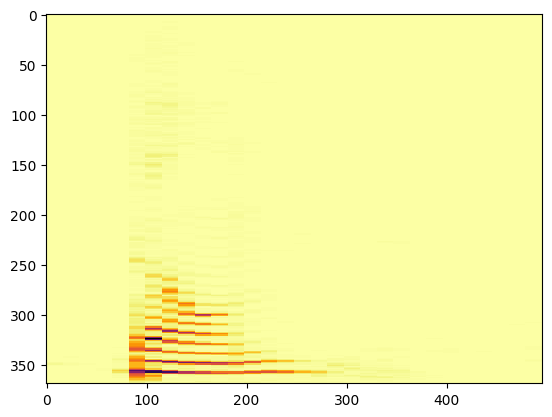

down


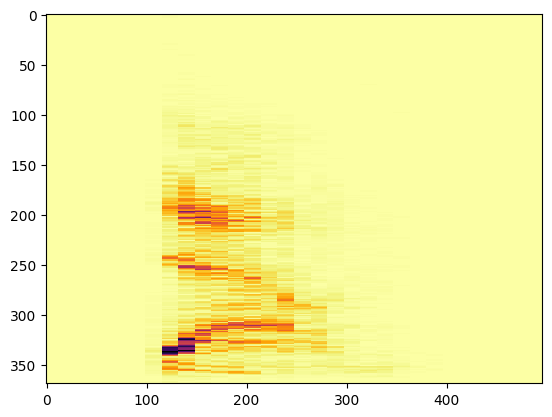

no


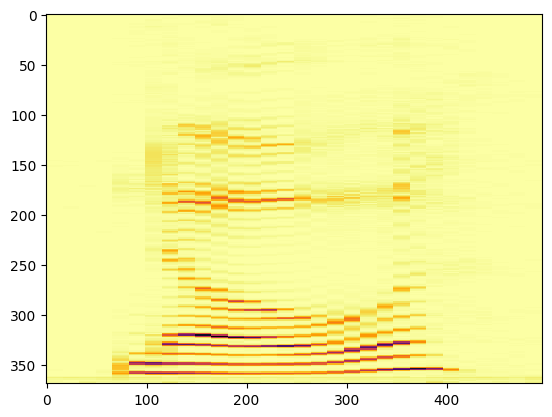

Number of elements which are allowed to change: 2400.0.


In [89]:
wavs = list(map(str, Path(AUDIO_TEST).rglob('*.wav')))

for i in [0, 100, 700]:
    cls = os.path.basename(Path(wavs[i]).parent)
    print(cls)
    wave = read_wave(wavs[i])
    spec = non_diff_spec(tf.convert_to_tensor(wave.ys)).numpy()[0]
    plt.imshow(spec)
    plt.show()
    
print(f"Number of elements which are allowed to change: {wave.ys.shape[0] * 0.15}.")

Model Loading

In [90]:
with tf.device('/cpu'):
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)

A function for prediction

In [91]:
def pred(wave):
    wave = tf.convert_to_tensor(wave.ys[None, :, None])
    spec = non_diff_spec(wave)
    with tf.device('/cpu'):
        ans = model(spec)
        return test_ds.class_names[tf.math.argmax(ans[0])]

It does not make sense to attack the portion of the audio file with silence. The most significant part where the word is pronounced. Such segment can be detected using the utitlities of special libraries.    

experimenting with different random segment, the careful choice of attacking the segment with the word's pronunciation leads to the best results. It is crucial to note that even the segment in question might be larger that the number of timestamps we are allowed to modify. The starting point in such case is random. The randomness led to the best results.

In [92]:
def detect_active_region(audio, sr=16000, thresh=5e-3):
    hop = int(1e-2 * sr)
    energy = librosa.feature.rms(y=audio, 
                                 frame_length=int(1e-2 * sr), 
                                 hop_length=hop)[0]

    voiced_frames = np.where(energy > thresh)[0]
    voiced_segments = librosa.frames_to_time(voiced_frames, sr=sr, hop_length=hop)
    if len(voiced_segments) <= 1:
        return 0, 1
    
    return voiced_segments.min(), voiced_segments.max()

The idea of fooling a neural network is to introduce a distortion which doesn't prevent human from classifying the audio correctly, but leads to an incorrect prediction by a neural network.

A good candidate for this task is to add a small noise to an image, use downsampling, change audio quality, etc. This can in general be called an augmentation. During training this technique could help to make the model more robust and to generalize better. However, if it wasn't use during training and the model has overfitted on the training data, such augmented samples can become a challange during test-time. Thus, I will try to use it for this task.

Additionally, there 2 other possible approachs:
1. Modifying the audio by modeling it using my work from the 1st assignment
2. Adding noise to the original audio and then extracting the noisy spectogram

In [93]:
augment = A.Compose([
    A.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1),
    A.PitchShift(min_semitones=-4, max_semitones=4, p=1),
    A.AirAbsorption(p=1),
    A.BandPassFilter(p=1),
    A.TanhDistortion(min_distortion=0.01, max_distortion=0.7, p=1.0)
])

In [94]:
# we can use this function to approximate the slice of the wave to modify
from linear_sinusoidal_modeling import approximate_wave

# this function can be used to add noise. 
def add_guassian_noise(wave, is_file:bool=False, snr:float=20, display_result=True):
    """This function given an initial wave, noise signal and a signal to ration noise,
      will generate a new wave by adding the passed noise with the specified snr

    Args:
        wave (Wave or str): the wave to which the noise is added or its path
        is_file (bool, optional): whether the wave is to be read from a file. Defaults to False.
        snr (float, optional): abbreviation of sigal to noise ratio . Defaults to 20.
    """
    # first calculate the amplitude of the initial wave
    if is_file:
        wave = read_wave(wave)
    
    amp_wave = np.max(wave.ys)
    # let's calculate the amplitude of the noise signal using snr

    noise_amp = amp_wave / np.sqrt(snr)
    
    # creating a noise signal
    noise_signal = UncorrelatedGaussianNoise(noise_amp)
    # creating the instance using the initial wave parameters
    noise_wave = noise_signal.make_wave(start=wave.start, duration=wave.duration, framerate=wave.framerate)
    # time to add the noise
    result_wave = noise_wave + wave
    
    # display if needed
    if display_result:
        print("THE GUASSIAN WAVE:")
        display(result_wave.make_audio())
        print()


    return result_wave

In [95]:
from scipy.spatial.distance import euclidean, cityblock

def portion_to_attack(wave: Wave, top_peaks:int=50, seg_length:int=256):
    # first create the spectrum
    spectrum = wave.make_spectrum()
    # extract the peaks
    peaks = spectrum.peaks()
    peaks = [p[1] for p in peaks[:top_peaks]]
    # let's round the peask
    peaks = [int (p / 10) * 10 for p in peaks]
    # extract the top peaks 
    # to associate the frequencies with the time stamps, let's use a spectogram
    spectrogram = wave.make_spectrogram(seg_length=seg_length)

    # iterate through each spectrum in the spectogram
    # and calculate the frequencies with the top
    
    best_start, best_p, best_dis= None, None, None

    for i, (_, spec) in enumerate(spectrogram.spec_map.items()):
        # extract the peaks of that spectrum
        spec_peaks = spec.peaks()[:top_peaks]
        spec_peaks = [int (p[1] / 10) * 10 for p in spec_peaks]
        # calculate the cosine difference between spec_peaks and the peaks 
        distance = cityblock(peaks[:len(spec_peaks)], spec_peaks) / len(spec_peaks)
        if best_dis is None or best_dis > distance:
            best_p = spec_peaks
            best_start = i
            best_dis = distance
    
    return best_start, seg_length # keep in mind the i-th segment : is the one from i * (seg_length // 2) (i + 1).
        

In [96]:
import random
from linear_sinusoidal_modeling import approximate_one_signal, SIGNALS


def attack(path):
    # Load the audio
    wave = read_wave(path)
    # Detect the range where there is a word
    fr, to = detect_active_region(wave.ys, sr=wave.framerate)
    # we will use the entire 15% of the time stamps
    if to - fr < 0.15:
        to = min(to + .15, 1)
        fr = max(fr - .15, 0)

    assert fr < to - 0.15, (fr, to)

    start_active = int(fr * len(wave.ys))
    end_active = int(to * len(wave.ys))

    seg_length = 2 ** int(np.log2(len(wave.ys) * 0.15)) 

    # the active region will be passed to portion_to_attack function
    active_wave = wave.slice(start_active, end_active)

    # determine the segment length
    
    start_index_active, seg_length = portion_to_attack(active_wave, seg_length=seg_length)

    final_start = start_active + start_index_active * (seg_length // 2)
    final_end = final_start + int(len(wave.ys) * 0.15) 

    attacked_wave = wave.slice(final_start, final_end)
    
    # disort the results
    prob = random.random()

    if prob <= 0.1:
        wave_slice_approx, _= approximate_one_signal(active_wave, signal=SIGNALS[0], n_trials=2)

        i = start_index_active * (seg_length // 2)
        # extract the attacked part
        wave_approx_attacked = wave_slice_approx.slice(i, i + int(len(wave.ys) * 0.15))
        
        # display(wave_slice_approx.make_audio())
        approx_len = len(wave_approx_attacked.ys)
        origin_len = len(wave.ys[final_start:final_end])
        min_len = min(approx_len, origin_len)
        wave_copy = wave.copy()
        # print(len(wave_slice_approx.ys))
        # print(wave_slice_approx.ys)

        for i in range(min_len):
            wave.ys[final_start + i ] += wave_approx_attacked.ys[i]

        # display(wave.slice(0, final_start).make_audio())
        # assert [i for i, (y1, y2) in enumerate(zip(wave.ys, wave_copy.ys)) if y1 != y2] == list(range(final_start, final_start + min_len))
        # display(wave.make_audio())
        return wave

    if prob <= 0.7:
        # 2nd approach: add noise to the slice in question and then exchange the values with the noisey slice 
        # print("GAUSSIAN noise!!!")
        wave_slice_approx = add_guassian_noise(attacked_wave, display_result=False, snr=150)
        approx_len = len(wave_slice_approx.ys)
        origin_len = len(wave.ys[final_start:final_end])
        min_len = min(approx_len, origin_len)
        wave.ys[final_start:final_start + min_len] = wave_slice_approx.ys[: min_len]
        return wave       

    # 3rd approach
    # Rewrite the segment with an augmented version
    wave.ys[final_start: final_end] = augment(wave.ys[final_start: final_end], sample_rate=16000)

    return wave


In [98]:
# wavs = list(map(str, Path(AUDIO_TEST).rglob('*.wav')))
# w = read_wave(wavs[10])
# start, seg = portion_to_attack(w, seg_length=2 ** 13)

# fr, to = detect_active_region(w.ys, sr=w.framerate)
# print(fr, to)
# print(len(w.ys) * 0.15)
# print(start, seg)

# slice_start = start * seg
# slice_end = (start + 1) * seg

# display(wave.make_audio())
# display(wave.slice(slice_start, slice_end).make_audio())

0.14 0.87
2400.0
0 8192


Now, apply the attack to all samples in the dataset.

In [99]:
def helper(i):
    """
    A helper function for processing of a single wave
    """
    # Extract real class of the wave
    real_cls = os.path.basename(Path(i).parent)
    # Prediction of the model for unmodified wave
    orig_wave = read_wave(i)
    orig_pred = pred(orig_wave)
    # If the model already fails on this sample 
    # - we don't need to do anything
    if orig_pred != real_cls:
        adv_wave = orig_wave
        adv_pred = orig_pred
    else:
        # Prediction of the model for modified wave
        adv_wave = attack(i)
        adv_pred = pred(adv_wave)
    
    return real_cls, orig_pred, adv_pred

In [100]:
out = list(map(helper, tqdm(wavs)))
    
real_clss, orig_preds, preds = zip(*out)
real_clss = np.array(real_clss)
orig_preds = np.array(orig_preds)
preds = np.array(preds)

  0%|          | 0/1599 [00:00<?, ?it/s]

SVD did not converge in Linear Least Squares
SVD did not converge in Linear Least Squares


In [101]:
orig_preds = np.array(orig_preds)
preds = np.array(preds)
real_clss = np.array(real_clss)

In [102]:
def acc(y1, y2):
    return np.sum(y1 == y2) / len(y1)

You can see that my strategy decreases the accuracy of the model by 10%

In [103]:
acc(real_clss, orig_preds), acc(real_clss, preds)

(0.6929330831769857, 0.6291432145090682)

Here is an illustration of my attack: you can hear that the distortion is quite small so a human can still recognize a word. However, the model fails giving a completely incorrect result.

In [111]:
random.seed(0)
np.random.seed(0)
for i in [47, 103, 50]:    
    real_cls = os.path.basename(Path(wavs[i]).parent)
    # real_cls = re.findall(r'/(\w+)/', wavs[i])[0]
    orig_wave = read_wave(wavs[i])
    display(orig_wave.make_audio())
    orig_pred = pred(orig_wave)
    adv_wave = attack(wavs[i])
    display(adv_wave.make_audio())
    adv_pred = pred(adv_wave)
    print(i, real_cls, orig_pred, adv_pred)

47 down down right


103 down down yes


50 down down down
